# Image-to-image translation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from src.utils import get_files

Using TensorFlow backend.


## Import frames

In [2]:
base_dir = '/Users/jcboyd/Data/IncuCyte/ZG-MS-CD8T_cytotoxicity/'
experiment = 'raji_target'

train_files, val_files, test_files = get_files(base_dir, experiment)

all_files = train_files + val_files

to_export = []

for i in range(0, len(all_files), 110):  # jump over fields

    for j in range(0, 48, 12):  # jump one day at a time

        to_export.append(all_files[i + j])

pc_img, gfp_img = [], []

for file_name in to_export:

    pc_img.append(imread(os.path.join(base_dir, 'phase_contrast', file_name)))
    gfp_img.append(imread(os.path.join(base_dir, 'GFP_calibrated', file_name)))

No. train images: 1540
No. val images: 110
No. test images: 110


/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2616: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2551: UserWarning: unpack: buffer size must be a multiple of element size
  warnings.warn("unpack: %s" % e)


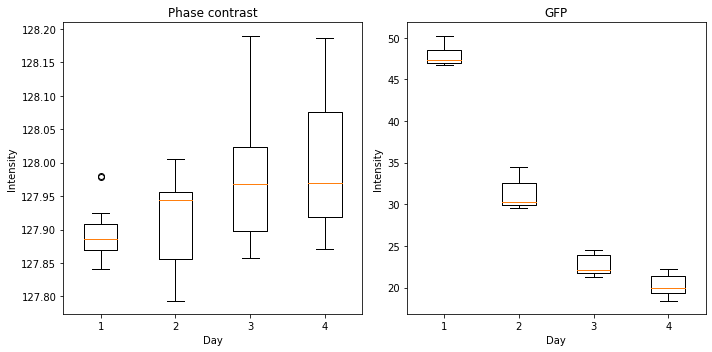

In [3]:
pc_means = [[np.mean(pc_img[i]) for i in range(j, 56, 4)] for j in range(4)]
gfp_means = [[np.mean(gfp_img[i]) for i in range(j, 56, 4)] for j in range(4)]

fig, axes = plt.subplots(figsize=(10, 5), ncols=2)

_ = axes[0].boxplot(pc_means)
axes[0].set_title('Phase contrast')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Intensity')

_ = axes[1].boxplot(gfp_means)
axes[1].set_title('GFP')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Intensity')

plt.tight_layout()

## Normalise images

In [4]:
def preprocess_pc(img):

    return img / 255.

pc_img = [preprocess_pc(img) for img in pc_img]

def preprocess_gfp(img):

    # normalise
    q_min = np.percentile(img, q=1)
    q_max = np.percentile(img, q=99)

    img = np.clip(img, q_min, q_max)
    img = (img - q_min) / (q_max - q_min)

    # threshold
    img[img < 0.05] = 0
    
    return img

gfp_img = [preprocess_gfp(img) for img in gfp_img]

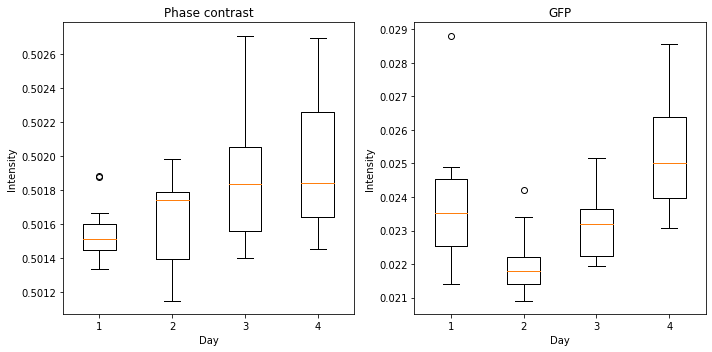

In [5]:
pc_means = [[np.mean(pc_img[i]) for i in range(j, 56, 4)] for j in range(4)]
gfp_means = [[np.mean(gfp_img[i]) for i in range(j, 56, 4)] for j in range(4)]

fig, axes = plt.subplots(figsize=(10, 5), ncols=2)

_ = axes[0].boxplot(pc_means)
axes[0].set_title('Phase contrast')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Intensity')

_ = axes[1].boxplot(gfp_means)
axes[1].set_title('GFP')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Intensity')

plt.tight_layout()

## Extract crops

In [6]:
crop_size = 256

crops = []

for pc, gfp in zip(pc_img, gfp_img):

    for y in range(0, pc.shape[0] - crop_size, crop_size):

        for x in range(0, pc.shape[1] - crop_size, crop_size):

            pc_crop = pc[y:y+crop_size, x:x+crop_size]
            gfp_crop = gfp[y:y+crop_size, x:x+crop_size]

            crops.append(np.hstack([pc_crop, gfp_crop]))

crops = np.stack(crops)
x_train, x_test = crops[:1120], crops[1120:]

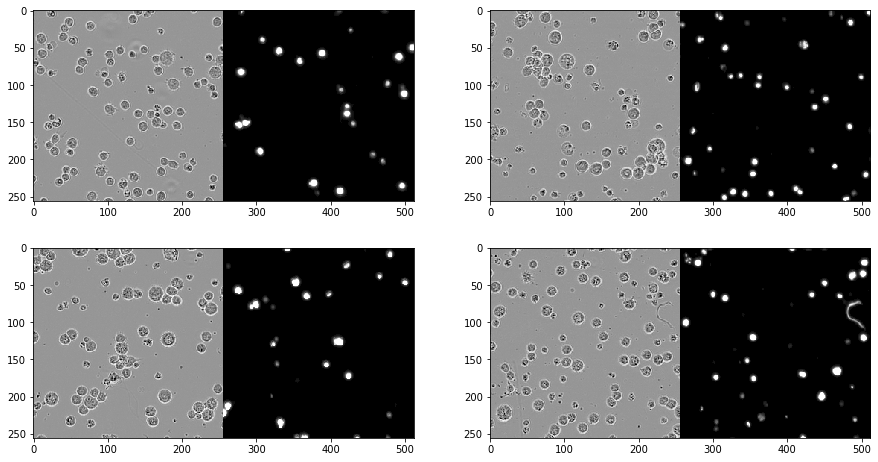

In [7]:
fig, axes = plt.subplots(figsize=(15, 8), ncols=2, nrows=2)

for i in range(4):
    idx = np.random.randint(x_train.shape[0])
    axes[i // 2][i % 2].imshow(x_train[idx], cmap='Greys_r')

## Train models

### Train pix2pix

Pix2pix is a system for paired image-to-image translation. It is the predecessor of CycleGANs, although those are based on a rather different architecture. Pix2pix is a conditional GAN algorithm with U-Net (see below) generator. Rather than transforming Gaussian noise, the generator works directly on a source image. The discriminator receives both source and target images . The discriminator is a fully-convolutional network that produces a grid of classifications, rather than a single one.

The power of pix2pix is in its learning of its own loss function (through the generator), whereas typical loss functions exhibit problems.

Isola, Phillip, et al. "Image-to-image translation with conditional adversarial networks." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.

In [8]:
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
from src.models import fnet, patch_gan
from src.utils import set_trainable

h, w, c = x_train.shape[1], x_train.shape[2] // 2, 1

img_shape = (h, w, c)
disc_patch = (h // 2 ** 4, w // 2 ** 4, c)

optimizer = Adam(0.0002, 0.5)

# Build discriminator
discriminator = patch_gan(img_shape)
discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = fnet(img_shape, 64, 'tanh')

# Input images and their conditioning images
images = Input(shape=img_shape)
labels = Input(shape=img_shape)

# By conditioning on B generate a fake version of A
fake_labels = generator(images)

set_trainable(discriminator, False)

# Discriminators determines validity of translated images / condition pairs
valid = discriminator([fake_labels, images])

combined = Model(inputs=[images, labels], outputs=[valid, fake_labels])
combined.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer=optimizer)

In [9]:
from src.utils import gen_pix2pix, sample_images

epochs = 200
batch_size = 1

# Adversarial loss ground truths
valid = np.ones((batch_size,) + disc_patch)
fake = np.zeros((batch_size,) + disc_patch)

train_gen = gen_pix2pix(crops)
steps_per_epoch = x_train.shape[0] // batch_size // 4

for epoch in range(epochs):

    for batch_i in range(steps_per_epoch):

        images, labels = next(train_gen)

        # Train discriminator - condition on B and generate a translated version
        fake_labels = generator.predict(images)

        set_trainable(discriminator, True)

        # Train the discriminators (original images = real / generated = Fake)
        d_loss_real = discriminator.train_on_batch([images, labels], valid)
        d_loss_fake = discriminator.train_on_batch([images, fake_labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        set_trainable(discriminator, False)

        # Train the generators
        g_loss = combined.train_on_batch([images, labels], [valid, labels])
        
        generator.save_weights('./weights/pix2pix.h5')
        discriminator.save_weights('./weights/patch_gan.h5')

        # Plot the progress
        print('[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f]' % (
            epoch, epochs, batch_i, steps_per_epoch, d_loss[0], 100 * d_loss[1], g_loss[0]))

    sample_images(generator, x_test, 'pix2pix', epoch)

generator.save_weights('./weights/pix2pix.h5')
discriminator.save_weights('./weights/patch_gan.h5')

### Train FNet

F-Net (fluorescence?) is an adaptation of U-Net for predicting fluorescence images from TL microscopy.

Ounkomol, Chawin, et al. "Label-free prediction of three-dimensional fluorescence images from transmitted-light microscopy." Nature methods 15.11 (2018): 917.

Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [10]:
from keras.optimizers import Adam

model = fnet(img_shape, num_filters=64, activation='linear')

opt = Adam(0.0002, 0.5)
model.compile(loss='mse', optimizer=opt)

In [11]:
from keras.callbacks import ModelCheckpoint, LambdaCallback

sample_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: 
                                 sample_images(model, x_test, 'fnet_mse', epoch))

batch_size = 1
steps = x_train.shape[0] // batch_size // 4

train_gen = gen_pix2pix(x_train, batch_size=1)
val_gen = gen_pix2pix(x_test, batch_size=16)

model_checkpoint = ModelCheckpoint('./weights/fnet_mse.h5',
                                   monitor='val_loss',
                                   save_best_only=True)

model.fit_generator(train_gen, epochs=200, steps_per_epoch=steps,
                      validation_data=next(val_gen),
                      callbacks=[model_checkpoint, sample_callback])

## Model testing

There are several ways of comparing model outputs with the ground truth. One is MSE at the pixel level. Another is at the object level using a blob detection algorithm. A simple approach to blob detection is with a Laplacian of Gaussian filter. That is,

$$\Delta G_\sigma(x, y) * f(x, y) = [\nabla_{xx}G_\sigma(x, y) + \nabla_{yy}G_\sigma(x, y)] * f(x, y)$$

where $\Delta$ is the Laplacian operator (sum of second partial derivatives), $G_\sigma$ is a Gaussian filter with standard deviation $\sigma$ and $f$ is an image. Blobs are Gaussian-like, and the Gaussian pre-filter smooths the image. The second derivative of a Gaussian has a minimum in the center of bell curve, thus marking the center of the blob. The maxima detected in the resultant image are the detected blobs. Usually the filter is performed over a range of scales, with the maxima taken over the z-stack.

Below explore the results over crops on the validation set. Ultimately it should be done on all test images, and time lapse videos should be produced for human adjudication. Note that this can be done without cropping as all generators are fully convolutional.

In [12]:
from skimage.feature import blob_log
from src.utils import get_blobs, gen_pix2pix
from src.vis_utils import plot_blobs

test_gen = gen_pix2pix(x_test, batch_size=1)
image, labels = next(test_gen)

### pix2pix

In [13]:
pix2pix = fnet(img_shape, 64, 'tanh')
pix2pix.load_weights('./weights/pix2pix.h5')

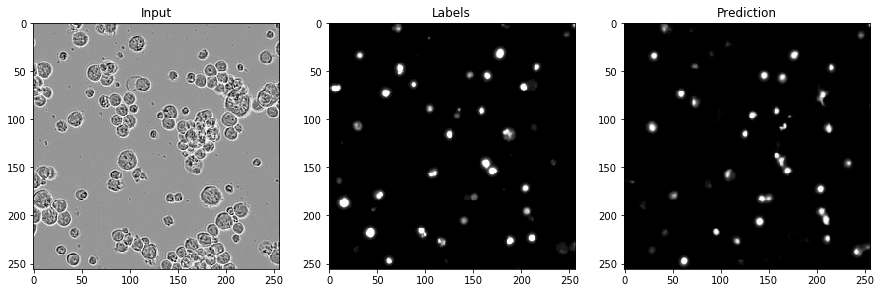

In [14]:
pred = pix2pix.predict(image)

fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

for ax, im, title in zip(axes, [image, labels, pred], ['Input', 'Labels', 'Prediction']):
    ax.set_title(title)
    ax.imshow(im.squeeze(), cmap='Greys_r')

In [15]:
mse = np.mean((labels.flatten() - pred.flatten()) ** 2)
print('MSE: %.04f' % mse)

MSE: 0.0418


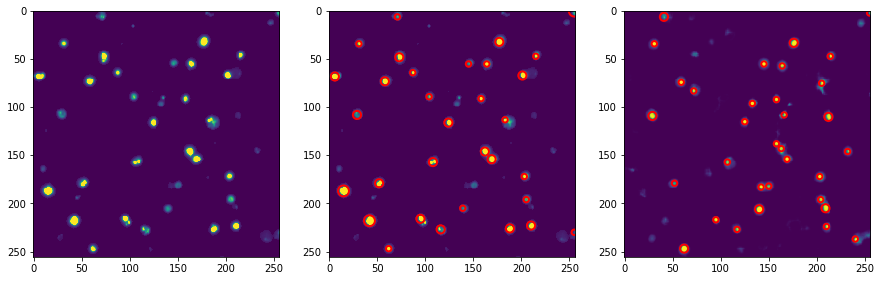

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

img = labels.squeeze()
true_blobs = get_blobs(img)
axes[0].imshow(img)
plot_blobs(axes[1], img, true_blobs)

img = pred.squeeze()
pred_blobs = get_blobs(pred.squeeze())

plot_blobs(axes[2], img, pred_blobs)

plt.show()

In [17]:
from src.utils import evaluate_blobs

tp, fp, fn = evaluate_blobs(true_blobs, pred_blobs)
print('True positives: %d, False positives: %d, False negatives: %d' % (tp, fp, fn))

True positives: 21, False positives: 12, False negatives: 11


### pix2pix ($\lambda = 0$)

If we set the pix2pix $L_1$ loss weight to $0$, we have a pure GAN system.

In [18]:
pix2pix_gan_only = fnet(img_shape, 64, 'tanh')
pix2pix_gan_only.load_weights('./weights/pix2pix_gan_only.h5')

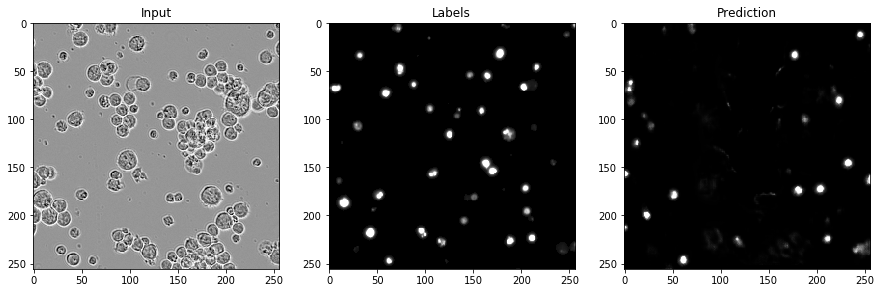

In [19]:
pred = pix2pix_gan_only.predict(image)

fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

for ax, im, title in zip(axes, [image, labels, pred], ['Input', 'Labels', 'Prediction']):
    ax.set_title(title)
    ax.imshow(im.squeeze(), cmap='Greys_r')

In [20]:
mse = np.mean((labels.flatten() - pred.flatten()) ** 2)
print('MSE: %.04f' % mse)

MSE: 0.0594


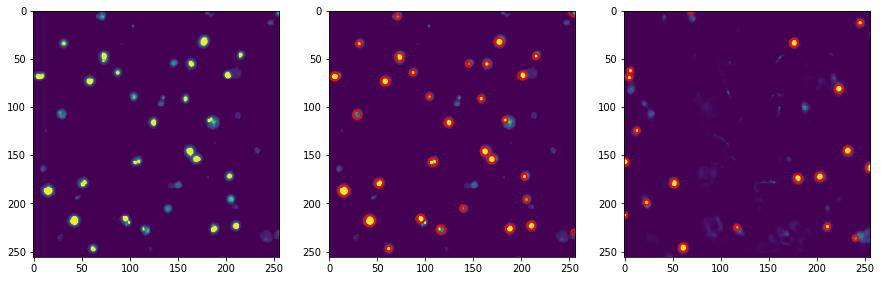

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

img = labels.squeeze()
true_blobs = get_blobs(img)
axes[0].imshow(img)
plot_blobs(axes[1], img, true_blobs)

img = pred.squeeze()
pred_blobs = get_blobs(pred.squeeze())

plot_blobs(axes[2], img, pred_blobs)

plt.show()

In [22]:
tp, fp, fn = evaluate_blobs(true_blobs, pred_blobs)
print('True positives: %d, False positives: %d, False negatives: %d' % (tp, fp, fn))

True positives: 7, False positives: 12, False negatives: 25


### $L_2$ loss

This is now F-Net

In [23]:
fnet_l2 = fnet(img_shape, 64, 'linear')
fnet_l2.load_weights('./weights/fnet_mse.h5')

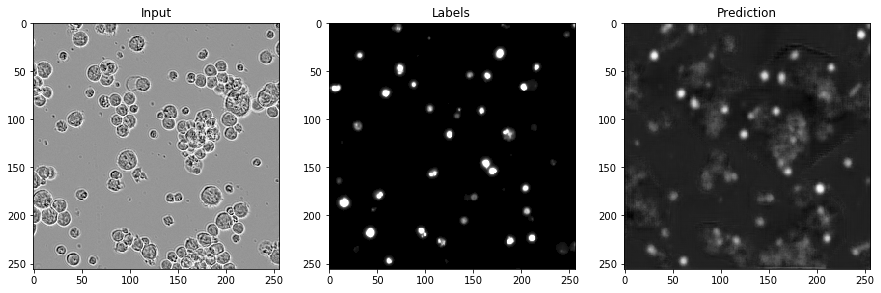

In [24]:
pred = fnet_l2.predict(image)

fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

for ax, im, title in zip(axes, [image, labels, pred], ['Input', 'Labels', 'Prediction']):
    ax.set_title(title)
    ax.imshow(im.squeeze(), cmap='Greys_r')

In [25]:
mse = np.mean((labels.flatten() - pred.flatten()) ** 2)
print('MSE: %.04f' % mse)

MSE: 0.0365


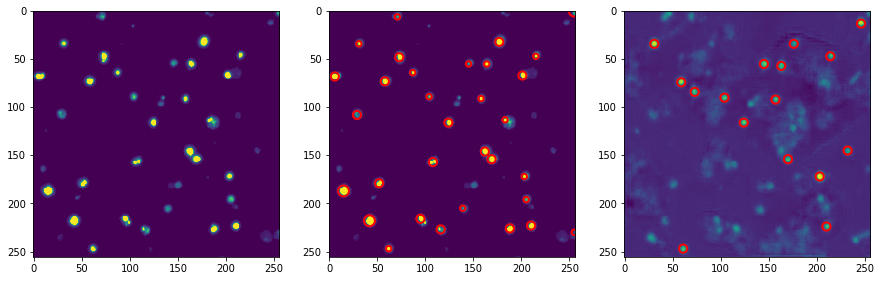

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

img = labels.squeeze()
true_blobs = get_blobs(img)
axes[0].imshow(img)
plot_blobs(axes[1], img, true_blobs)

img = pred.squeeze()
pred_blobs = get_blobs(pred.squeeze())

plot_blobs(axes[2], img, pred_blobs)

plt.show()

In [27]:
tp, fp, fn = evaluate_blobs(true_blobs, pred_blobs)
print('True positives: %d, False positives: %d, False negatives: %d' % (tp, fp, fn))

True positives: 13, False positives: 3, False negatives: 19


### $L_1$ loss

In [28]:
fnet_l1 = fnet(img_shape, 64, 'tanh')
fnet_l1.load_weights('./weights/fnet_mae.h5')

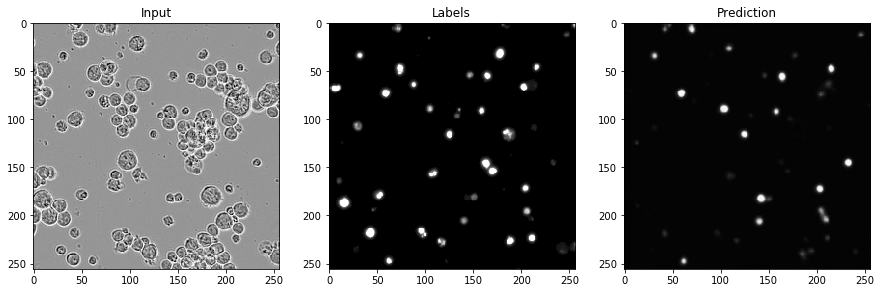

In [29]:
pred = fnet_l1.predict(image)

fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

for ax, im, title in zip(axes, [image, labels, pred], ['Input', 'Labels', 'Prediction']):
    ax.set_title(title)
    ax.imshow(im.squeeze(), cmap='Greys_r')

In [30]:
mse = np.mean((labels.flatten() - pred.flatten()) ** 2)
print('MSE: %.04f' % mse)

MSE: 0.0875


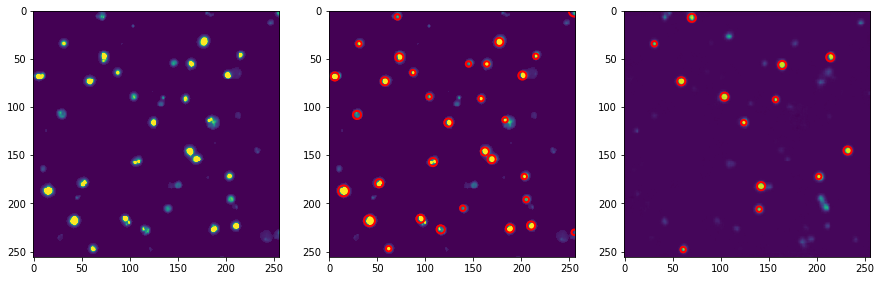

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

img = labels.squeeze()
true_blobs = get_blobs(img)
axes[0].imshow(img)
plot_blobs(axes[1], img, true_blobs)

img = pred.squeeze()
pred_blobs = get_blobs(pred.squeeze())

plot_blobs(axes[2], img, pred_blobs)

plt.show()

In [32]:
tp, fp, fn = evaluate_blobs(true_blobs, pred_blobs)
print('True positives: %d, False positives: %d, False negatives: %d' % (tp, fp, fn))

True positives: 11, False positives: 2, False negatives: 21


## Fully convolutional inference

Since the generators are all fully-convolutional (U-Net based), we can readily generate for larger (or smaller) image sizes than that of the training set.

In [33]:
img_shape = (None, None, c)  # arbitrary input dimensions

pix2pix = fnet(img_shape, 64, 'tanh')
pix2pix.load_weights('./weights/pix2pix.h5')

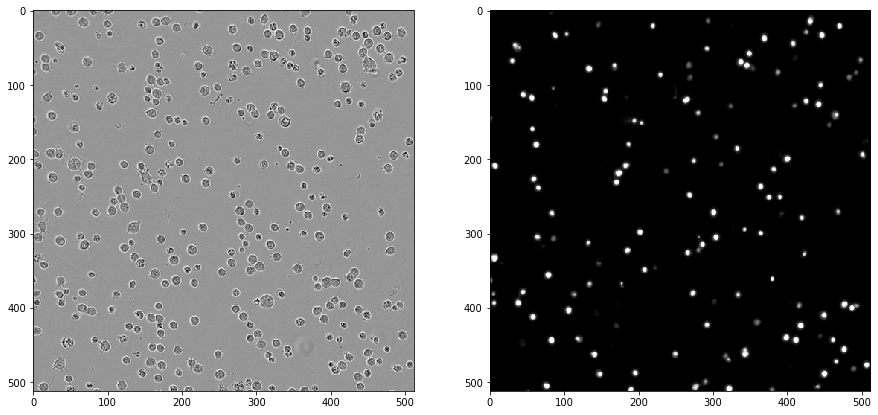

In [34]:
crop_size = 512

larger_input = 2 * pc_img[0][None, :crop_size, :crop_size, None] - 1
pred = pix2pix.predict(larger_input)

fig, axes = plt.subplots(figsize=(15, 10), ncols=2)

axes[0].imshow(larger_input.squeeze(), cmap='Greys_r')
axes[1].imshow(pred.squeeze(), cmap='Greys_r')

## Full evaluation

In [35]:
all_mse, all_tp, all_fp, all_fn = [], [], [], []

models = {'pix2pix' : pix2pix, 'pix2pix_gan_only' : pix2pix, 'fnet_l2' : fnet_l2, 'fnet_l1' : fnet_l1}

for model_name in models.keys():
    print('Evaluating %s...' % model_name)

    arr_mse, arr_tp, arr_fp, arr_fn = [], [], [], []

    for x in x_test:

        x = x[None, ...]

        test_gen = gen_pix2pix(x)
        images, labels = next(test_gen)

        pred = models[model_name].predict(images)

        # calculate mse
        mse = np.mean((labels.flatten() - pred.flatten()) ** 2)
        arr_mse.append(mse)

        # calculate accuracies
        true_blobs = get_blobs(labels.squeeze())
        pred_blobs = get_blobs(pred.squeeze())

        tp, fp, fn = evaluate_blobs(true_blobs, pred_blobs)
        arr_tp.append(tp); arr_fp.append(fp); arr_fn.append(fn)

    all_mse.append(arr_mse)
    all_tp.append(arr_tp); all_fp.append(arr_fp); all_fn.append(arr_fn)

Evaluating pix2pix...
Evaluating pix2pix_gan_only...
Evaluating fnet_l2...
Evaluating fnet_l1...


### Mean squared error

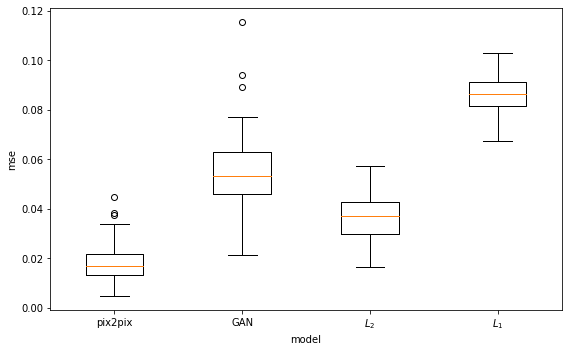

In [36]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.boxplot(all_mse)
ax.set_xlabel('model')
ax.set_xticklabels(['pix2pix', 'GAN', '$L_2$', '$L_1$'])
ax.set_ylabel('mse')

plt.tight_layout()

### Precision, recall, $F_1$

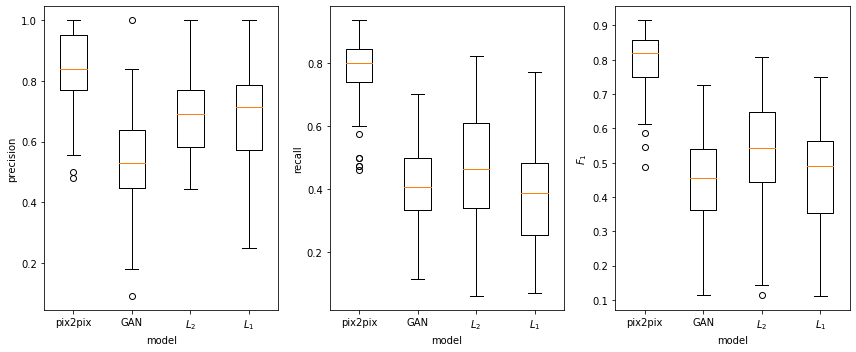

In [37]:
fig, axes = plt.subplots(figsize=(12, 5), ncols=3)

all_precision = [np.array(tps) / (np.array(tps) + np.array(fps))
              for tps, fps in zip(all_tp, all_fp)]

all_recall = [np.array(tps) / (np.array(tps) + np.array(fns))
              for tps, fns in zip(all_tp, all_fn)]

all_f1 = [2 * (precision * recall) / (precision + recall)
          for precision, recall in zip(all_precision, all_recall)]

for ax, ylabel, statistics in zip(axes,
                              ['precision', 'recall', '$F_1$'],
                              [all_precision, all_recall, all_f1]):
    ax.boxplot(statistics)
    ax.set_xlabel('model')
    ax.set_xticklabels(['pix2pix', 'GAN', '$L_2$', '$L_1$'])
    ax.set_ylabel(ylabel)

plt.tight_layout()

## PatchGAN

Each pixel of the $16 \times 16$ output of the PatchGAN discriminator has an (overlapping) receptive field of $64 \times 64$ pixels in the original image.

In [38]:
discriminator = patch_gan(img_shape)
discriminator.load_weights('./weights/patch_gan.h5')

test_gen = gen_pix2pix(x_test, batch_size=1)
image, labels = next(test_gen)

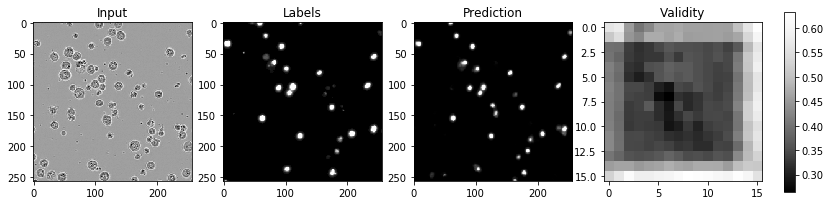

In [39]:
pred = pix2pix.predict(image)
outputs_pix2pix = discriminator.predict([image, pred])

fig, axes = plt.subplots(figsize=(15, 5), ncols=4)

for ax, im, title in zip(axes, [image, labels, pred, outputs_pix2pix], ['Input', 'Labels', 'Prediction', 'Validity']):
    ax.set_title(title)
    im = ax.imshow(im.squeeze(), cmap='Greys_r')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.25, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)

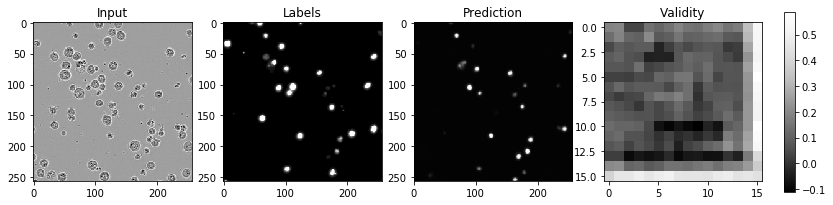

In [40]:
pred = fnet_l1.predict(image)
outputs_l1 = discriminator.predict([image, pred])

fig, axes = plt.subplots(figsize=(15, 5), ncols=4)

for ax, im, title in zip(axes, [image, labels, pred, outputs_l1], ['Input', 'Labels', 'Prediction', 'Validity']):
    ax.set_title(title)
    im = ax.imshow(im.squeeze(), cmap='Greys_r')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.25, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)